In [1]:
#Install some dependencies
%pip install pyarrow hls4ml pyparser

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.



# Quantization aware training with QKeras

Quantization is a powerful way to reduce model memory and resource consumption. In this tutorial, we will use the libary QKeras to perform quantization aware training (QAT).

In contrast to in Keras, where models are trained using floating point precision, QKeras quantizes each of the model weights and activation functions during training, allowing the network to adapt to the numerical precision that will eventually be used on hardware.

During the forward pass of the network, each floating point weight is put into one of $2^{bitwidth}$ buckets. Which one it goes into is defined through rounding and clipping schemes.

Below you can see an example of a tensor with a (symmetric) dynamic range of $x_{f}$ $[-amax, amax]$ mapped through quantization to a an 8 bit integer, $2^8=256$ discrete values in the interval $[-128, 127]$ (32-bit floating-point can represent ~4B numbers in the interval $[-3.4e38, 3.40e38]$).

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/8-bit-signed-integer-quantization.png?ref_type=heads" width="800"/>

Quantization of floating point numbers can be achieved using the quantization operation

$$x_{q} = Clip(Round(x_{f}/scale))$$

where $x_{q}$ is the quantized digit and $x_{f}$ is the floating point digit. $Round$ is a function that applies some rounding scheme to each number and $Clip$ is a function that clips outliers that fall outside the $[-128, 127]$ interval. The $scale$ parameter is obtained by dividing the float-point dynamic-range into 256 equal parts.

On FPGA, we do not use int8 quantization, but fixed-point quantization, bu the idea is similar. Fixed-point representation is a way to express fractions with integers and offers more control over precision and range. We can split the $W$-bits making up an integer (in our case $W=8$) to represent the integer part of a number and the fractional part of the number. We usually reserve 1-bit representing the sign of the digit. The radix splits the remaining $W-1$ bits to $I$ most significant bits representing the integer value and $F$ least significant bits representing the fraction. We write this as $<W,I>$, where $F=W-1-I$.  Here is an example for an unsigned $<8,3>$:

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/fixedpoint.png?ref_type=heads" width="400"/>


This fixed point number corresponds to $2^4\cdot0+2^3\cdot0+2^2\cdot0+2^1\cdot1+2^0\cdot0+2^{-1}\cdot1+2^{-2}\cdot1+2^{-3}\cdot0=2.75$.

The choice of $I$ and $F$ has to be derived as a trade-off between representation range and precision, where $I$ controls the range and $F$ the precision.

In the following we will use a bitwidth of 8 and 0 integer bits. Not considering the sign bit, this means that the smallest number you can represent (the precision) and the largest number (the range) is:

$$ \rm{Precision}= \frac{1}{2^{F}}= \frac{1}{2^8} = 0.00390625$$
$$\rm{Range}= [-2^0,-2^0-1]=[-1,0] $$
With zero integer bits the largest number you can represent is just below (but not including) 1. For weights in deep neural networks, being constrained to be less than 1 is often a reasonable assumtion.



What QKeras (and other QAT libraries) do, is to include the quantization error during the training, in the following way:
- "Fake quantize" the floating-point weights and activations during the forward pass: quantize the weights and use them for the layer operations
- Immediately un-quantize the parameters so the rest of the computations take place in floating-point
- During the backward pass, the gradient of the weights is used to update the floating point weight
- The quantization operation gradient (zero or undefined) is handled by passing the gradient through as is ("straight through estimator")

## Inspect the original model
In the following we will use the QKeras library to add quantizers to our model. First, let's load the baseline model and remind ourselves what the architecture looks like:


In [2]:
from tensorflow.keras.models import load_model
import os

part1_output_dir = os.environ['MLATL1T_DIR']+'/part1/part1_outputs/'

model_path =  part1_output_dir + '/model.h5'
baseline_model = load_model(model_path)

baseline_model.summary()

2023-12-07 16:03:13.291675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/afs/cern.ch/user/t/thaarres/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/afs/cern.ch/user/t/thaarres/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/afs/cern.ch/user/t/thaarres/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(sel

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 64)                3648      
                                                                 
 relu1 (Activation)          (None, 64)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                2080      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 1)                

2023-12-07 16:03:33.284567: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (34)


So we have 3 hidden layers with [64,32,32] neurons. We don't see it here, but they are all followed by an "elu" activation. The output is one node activated by a sigmoid activation function.

# Load the data from Part 1

Let's also load the data from part one already now so we know what the input shape is for defining our quantized model. Afterwards we'll also further process this input before training it.

In [3]:
import awkward as ak
import pickle

X_train = ak.from_parquet(part1_output_dir + "/X_train_scaled.parquet").to_numpy() 
X_test  = ak.from_parquet(part1_output_dir + "/X_test_scaled.parquet").to_numpy() 

y_train = ak.from_parquet(part1_output_dir + "/y_train_scaled.parquet").to_numpy()
y_test  = ak.from_parquet(part1_output_dir + "/y_test_scaled.parquet").to_numpy()

# In this case the test and train data is already scaled, but this is how you would laod and apply it:
#Load the scaler and parameters and apply to the data
scale = False
if scale:
    file_path = part1_output_dir+'/scaler.pkl'

    with open(file_path, 'rb') as file:
        scaler = pickle.load(file)

    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test);


print(f"Training on {X_train.shape[0]} events, represented by {X_train.shape[1]} input features")
print(f"Testing on {X_test.shape[0]} events, represented by {X_test.shape[1]} input features")

Training on 523217 events, represented by 56 input features
Testing on 523218 events, represented by 56 input features


## Translating to a QKeras QAT model
There are two ways to translate this into a QKeras model that can be trained quantization aware, lets first do it manually:

### Manual QKeras model definition:

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

input_size=X_train.shape[1]

# Define the input layer
inputs = Input(shape=(input_size,))

# Define the three hidden layers and output layer
hidden1 = QDense(
        64,
        name='qd1',
        kernel_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        bias_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        ) (inputs)
hidden1 = QActivation(activation=quantized_relu(8), name='qrelu1')(hidden1)
hidden2 = QDense(
        32,
        name='qd2',
        kernel_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        bias_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        ) (hidden1)
hidden2 = QActivation(activation=quantized_relu(8), name='qrelu2')(hidden2)
hidden3 = QDense(
        32,
        name='qd3',
        kernel_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        bias_quantizer=quantized_bits(bits=8, integer=0, symmetric=0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        ) (hidden2)
hidden3 = QActivation(activation=quantized_relu(8), name='qrelu3')(hidden3)
# Define the output layer with a single node, let's be careful with quantizing this one and be a bit more generous
# Some prefer to leave this a Keras Dense layer, but then it requires more manual tuning in the hs4ml part
logits = QDense(1, 
        name='logits',
        kernel_quantizer=quantized_bits(bits=13, integer=0, symmetric=0, alpha=1),
        bias_quantizer=quantized_bits(bits=13, integer=0, symmetric=0, alpha=1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        ) (hidden3)

output = Activation(activation='sigmoid', name='output')(logits)
# Create the model
qmodel = Model(inputs=inputs, outputs=output)

# Model summary
qmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56)]              0         
                                                                 
 qd1 (QDense)                (None, 64)                3648      
                                                                 
 qrelu1 (QActivation)        (None, 64)                0         
                                                                 
 qd2 (QDense)                (None, 32)                2080      
                                                                 
 qrelu2 (QActivation)        (None, 32)                0         
                                                                 
 qd3 (QDense)                (None, 32)                1056      
                                                                 
 qrelu3 (QActivation)        (None, 32)                0     

Wait! What is going on here?
The magic happens in ```quantized_bits``` (see implementation [here](https://github.com/google/qkeras/blob/master/qkeras/quantizers.py#L1245)), where the parameters are the following:
- ```bits```: The bitwidth, allowing you to have $2^{bits}$ unique values of each weight parameter
- ```integers```: How many are integer bits, in this case zero. All 8 bits are used to represent the fractional part of the weight parameter, with no bits dedicated to representing whole numbers. This forces the value to be between -1 and 1. For DNNs this can be useful because the focus is entirely on the precision of the fraction rather than the magnitude of the number. Question: Would this also work on the output node if your algorithm is a regression of the jet mass?
- ```symmetric```: should the values be symmetric around 0? In this case it doesnt have to be.
- ```alpha```: with $2^W$ unique values available, we could let them go from $[-2^W, 2^W-1]$ like above, but we can also let them go from $[-2^W*\alpha, (2^W-1)*\alpha]$. ```alpha``` is a scaling of the weights. Enabling this often leads to improved performance, but it doesnt talk so nicely to hls4ml, so we recommend leaving it at 1 (or get ready for having to debug)

Having added this, QKeras will automatically apply fake quantization for us during the forward pass, accounting for the quantization error and returning a network that is optimized for the precision you plan on using in hardware.

Another thing to notice is that we leave the sigmoid and the final output logit unquantized. This is because this is were we want the values to be very accurate, and it is not going to save us a lot of resources quantizing it.


### Automatic model quantization through config
 You can also set the quantization for the full model using a model configuration. Sometimes this can be sater if you're using the same quantizer for all layers of the same type. You don't have to use this for this tutorial, we already have a model, but we will leave it here as an example:

In [5]:
autoQuant = False

if autoQuant:
    config = {
      "QDense": {
          "kernel_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
          "bias_quantizer": "quantized_bits(bits=8, integer=0, symmetric=0, alpha=1)",
      },
      "QActivation": { "relu": "quantized_relu(8)" }
    }
    from qkeras.utils import model_quantize

    qmodel = model_quantize(model, config, 4, transfer_weights=True)

    for layer in qmodel.layers:
        if hasattr(layer, "kernel_quantizer"):
            print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
        elif hasattr(layer, "quantizer"):
            print(layer.name, "quantizer:", str(layer.quantizer))

    print()
    qmodel.summary()


But be careful that activation functions like softmax/sigmoid and perhaps logit layers you want to keep at full presision doesn't get quantized!

## But how many bits?

So now we know how to quantize our models, but how do we know wich precision to choose?
Finding the best number of bits and integer bits to use is non-trivial, and there are two ways we recommend:
- The easiest strategy is to scan over the possible bit widths from binary up to some maximum value and choose the smallest one that still has acceptable accuracy, and this is what we often do. 
Code for how to do this can be found [here](https://github.com/thesps/keras-training/blob/qkeras/train/train_scan_models.py#L16), and is illustrated below.
For binary and ternary quantization, we use the special ```binary(alpha=1.0)(x)``` and ```ternary(alpha=1.0)(x)``` quantizers. 

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/quant_scan.png?ref_type=heads" width="400"/>

- Another thing you can do is to use our library for automatic quantization, [AutoQKeras](https://github.com/google/qkeras/blob/master/notebook/AutoQKeras.ipynb), to find the optimal quantization for each layer. This runs hyperparameter optimisation over quantizers/nodes/filters simultenously. An example can be found at the end of [this notebook](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part6_cnns.ipynb) "Bonus exercise: Automatic quantization with AutoQKeras".

## Pruning

Besides reducing the numerical precision of all the weights, biases and activations, I also want to remove neurons and synapses that do not contribute much to the network overall decision. We do that by pruning, let's remove 50\% of the weights (spasity=0.5):

In [6]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

# The training step is one gradient update, or epochs*N_samples/batchsize
pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.5, begin_step=6000, frequency=10)}
qmodel = prune.prune_low_magnitude(qmodel, **pruning_params)

## Defining the data input type
Great, we now have our model ready to be trained! There is one last important thing we have to think about and that is the *precision of the input*.  In the L1T, all of the inputs are quantized. For instance, the precision used for the GT is listed [here](https://github.com/cms-l1-globaltrigger/mp7_ugt_legacy/blob/master/doc/scales_inputs_2_ugt/pdf/scales_inputs_2_ugt.pdf).

Ideally, when you train your network, you use the hardware values that the algorithm will actually receive when running inference in the trigger.

We saw, however, that the inputs were all scaled to have a mean of zero and variance of one in the previous exercise. That means that the new optimal precision for the inputs have changes and you need to define what the precision will be. Here we will do it by inspection and intuition, and use the same precision for all of the input features. Let's now load, scale the data and look at the input value distribution:

<module 'matplotlib.pyplot' from '/cvmfs/cms.cern.ch/slc7_amd64_gcc11/external/py3-matplotlib/3.7.1-437a2eea83d29aac3bc5f3984f238002/lib/python3.9/site-packages/matplotlib/pyplot.py'>

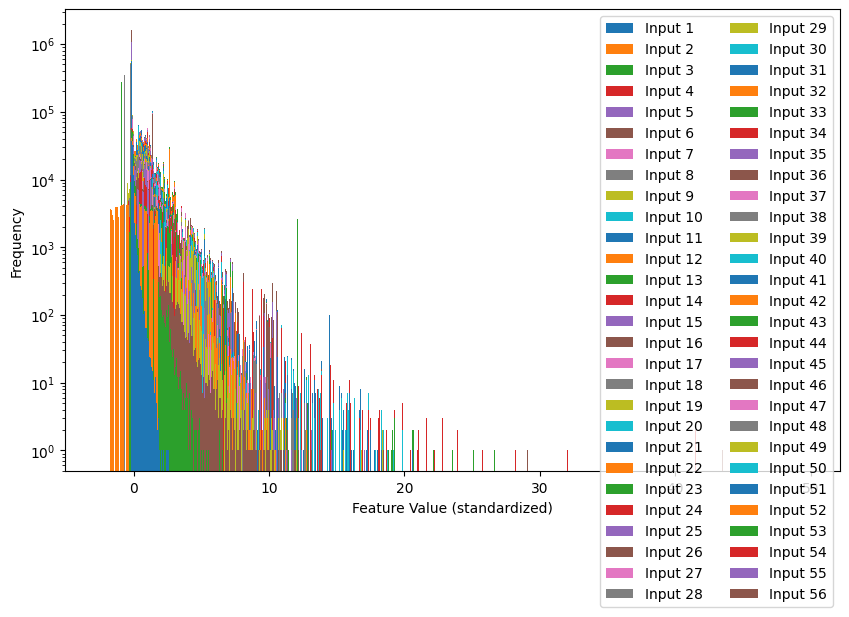

In [7]:

import matplotlib.pyplot as plt

bins = 4096

plt.figure(figsize=(10, 6))
#Input distribution, stacked per feature. This is very slow to plot, so lets look at all the features flattened later on
plt.hist(X_train, bins=bins, stacked=True, label=[f'Input {i+1}' for i in range(X_train.shape[1])]) 
# plt.hist(X_train.flatten(), bins=bins, color='orangered', label='Floating point')
plt.xlabel('Feature Value (standardized)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', ncol=2)
plt.semilogy()
plt

In this case, the values seem to be mostly <50, with a few outliers so lets assume 6 integer bits ($2^6=64$) is sufficient (the rest will get clipped). The number of fractional bits will define our precision, and will affect the network performance. Let's assume 10 is sufficient (the smallest increment we can represent is $2^{-10}=0.0009765625$).

We can evaluate these choices by comparing the accuracy of the network to that in the previous part. 

To make our network adapt to this input precision, we need to "treat" our training and testing set with a quantizer to go from FP32 $\rightarrow <16,6>$:

In [8]:
import numpy as np
input_quantizer = quantized_bits(bits=16, integer=6, symmetric=0, alpha=1)
qX_train = input_quantizer(X_train.astype(np.float32)).numpy()
qX_test = input_quantizer(X_test.astype(np.float32)).numpy()

# Save the quantized test data and labels to a numpy file, such that it can be used to test the firmware
np.save('qX_test.npy', qX_test)
np.save('qy_test.npy', y_test)


<module 'matplotlib.pyplot' from '/cvmfs/cms.cern.ch/slc7_amd64_gcc11/external/py3-matplotlib/3.7.1-437a2eea83d29aac3bc5f3984f238002/lib/python3.9/site-packages/matplotlib/pyplot.py'>

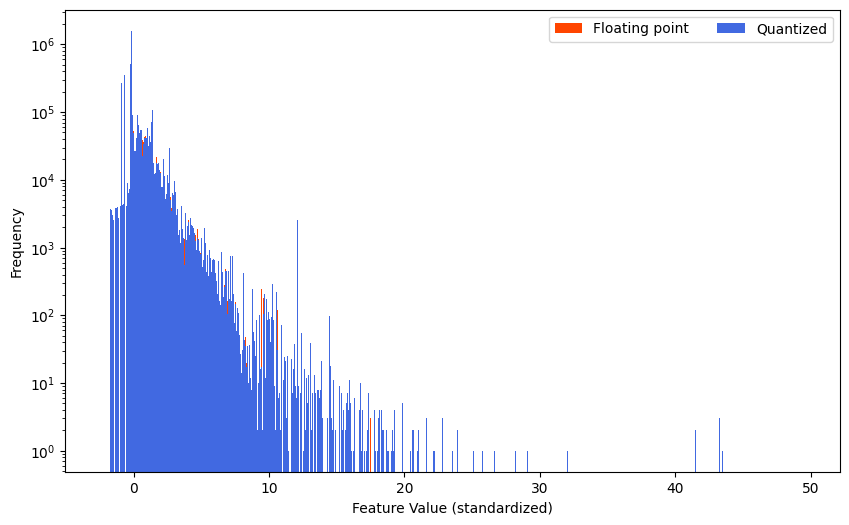

In [9]:
plt.figure(figsize=(10, 6))

# plt.hist(qX_train, bins=bins, stacked=True, label=[f'Input {i+1}' for i in range(X_train.shape[1])])
plt.hist(X_train.flatten(), bins=bins, color='orangered', label='Floating point')
plt.hist(qX_train.flatten(), bins=bins, color='royalblue', label='Quantized')
plt.xlabel('Feature Value (standardized)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', ncol=2)
plt.semilogy()
plt

The weight distribution looks similar, but we can not really say how much we lose in performance before training with different input precisions.

## Train the network quantization aware
Phew, okay, finally time to train. For this part there are 2 things to note: you need to add a pruning callback and also you might need to adjust the learning rate (like add a learning rate decay). Also, most likely you need to increase the number of epochs.

Let's train!

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

model_checkpoint = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, monitor='val_loss')
# This might result in returning a not fully pruned model, but that's okay!
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks=[early_stopping, reduce_lr, model_checkpoint, pruning_callbacks.UpdatePruningStep()]

adam = Adam(learning_rate=0.001)
qmodel.compile(optimizer=adam, loss=['binary_crossentropy'], metrics=['accuracy'])

qmodel.fit(qX_train, y_train, batch_size=4096, epochs=60,validation_split=0.20, shuffle=True,callbacks=callbacks,verbose=1) 
qmodel = strip_pruning(qmodel)
qmodel.save('qtopo_model.h5')

Epoch 1/60
103/103 [==============================] - 5s 14ms/step - loss: 0.3274 - accuracy: 0.9273 - val_loss: 0.1402 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 2/60
103/103 [==============================] - 1s 9ms/step - loss: 0.1138 - accuracy: 0.9913 - val_loss: 0.0988 - val_accuracy: 0.9923 - lr: 0.0010
Epoch 3/60
103/103 [==============================] - 1s 8ms/step - loss: 0.0905 - accuracy: 0.9927 - val_loss: 0.0828 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 4/60
103/103 [==============================] - 1s 7ms/step - loss: 0.0768 - accuracy: 0.9933 - val_loss: 0.0707 - val_accuracy: 0.9932 - lr: 0.0010
Epoch 5/60
103/103 [==============================] - 1s 7ms/step - loss: 0.0666 - accuracy: 0.9934 - val_loss: 0.0622 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 6/60
103/103 [==============================] - 1s 8ms/step - loss: 0.0586 - accuracy: 0.9936 - val_loss: 0.0551 - val_accuracy: 0.9935 - lr: 0.0010
Epoch 7/60
103/103 [==============================] - 1s 7ms/step - l

## Comparing to he floating point model

Before checking and comparing the accuracy, lets look at the weights and see if they look quantized and pruned:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Layer qd1: % of zeros = 0.0
Layer qd2: % of zeros = 0.0
Layer qd3: % of zeros = 0.0
Layer logits: % of zeros = 0.0


<module 'matplotlib.pyplot' from '/cvmfs/cms.cern.ch/slc7_amd64_gcc11/external/py3-matplotlib/3.7.1-437a2eea83d29aac3bc5f3984f238002/lib/python3.9/site-packages/matplotlib/pyplot.py'>

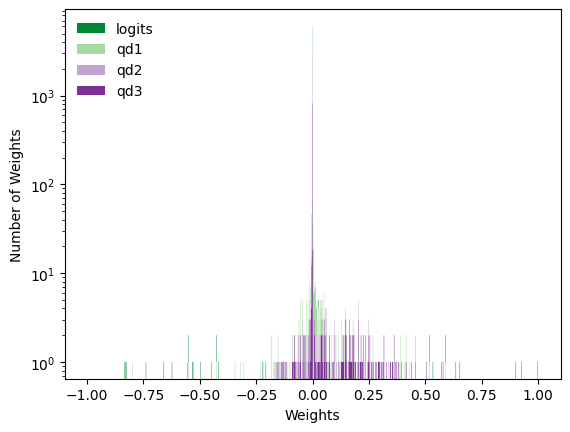

In [11]:
colors  = ['#7b3294','#c2a5cf','#a6dba0','#008837']
# TAKE EVERY OPPORTUNITY TO ADVERTISE COLORBLIND SAFE PLOTS :)

allWeightsByLayer = {}
for layer in qmodel.layers:
    layername = layer._name
    if len(layer.get_weights())<1:
      continue
    weights=layer.weights[0].numpy().flatten()  
    allWeightsByLayer[layername] = weights
    print('Layer {}: % of zeros = {}'.format(layername,np.sum(weights==0)/np.size(weights)))
labelsW = []
histosW = []
  
for key in reversed(sorted(allWeightsByLayer.keys())):
    labelsW.append(key)
    histosW.append(allWeightsByLayer[key])

fig = plt.figure()
ax = fig.add_subplot()
plt.semilogy()
plt.legend(loc='upper left',fontsize=15,frameon=False)
bins = np.linspace(-1, 1, 1024) 
ax.hist(histosW,bins,histtype='stepfilled',stacked=True,label=labelsW,color=colors)#, edgecolor='black')
ax.legend(frameon=False,loc='upper left')
axis = plt.gca()
plt.ylabel('Number of Weights')
plt.xlabel('Weights')
plt

This looks quantized and pruned indeed! Now, lets compare the performance to that of the floating point model. 

We are not so interested in false positive rate (FPR) and more interested in the absolute L1 rate, so lets convert it. We will Zoom into the region $<100$ kHz for obvious reasons, which means we are working at a very low FPR. 

Ealuating the performane at such high thresholds will require a lot of stiatistics, which luckily we have:

In [12]:
y_pred  = baseline_model.predict(X_test, batch_size = 4096)
qy_pred = qmodel.predict(qX_test, batch_size = 4096)

128/128 [==============================] - 1s 4ms/step


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

assert(len(y_test) == len(y_pred) == len(qy_pred)), "Inconsistent predicted and true!"
fpr, tpr, thr = roc_curve(y_test, y_pred, pos_label=None, sample_weight=None, drop_intermediate=True)
roc_auc = roc_auc_score(y_test, y_pred)

qfpr, qtpr, qthr = roc_curve(y_test, qy_pred, pos_label=None, sample_weight=None, drop_intermediate=True)
qroc_auc = roc_auc_score(y_test, qy_pred)

In [14]:
# Lets also convert from FPR to L1 rate:

def totalMinBiasRate():

    LHCfreq = 11245.6
    nCollBunch = 2544

    return LHCfreq * nCollBunch / 1e3 # in kHz
fpr *= totalMinBiasRate()
qfpr *= totalMinBiasRate()

<module 'matplotlib.pyplot' from '/cvmfs/cms.cern.ch/slc7_amd64_gcc11/external/py3-matplotlib/3.7.1-437a2eea83d29aac3bc5f3984f238002/lib/python3.9/site-packages/matplotlib/pyplot.py'>

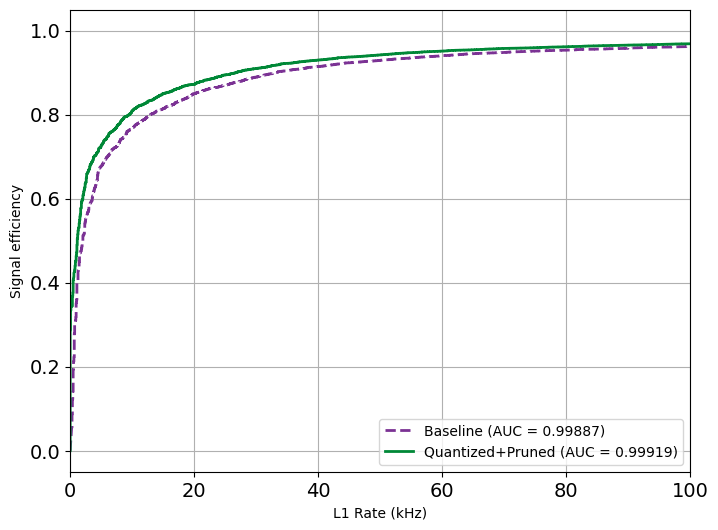

In [15]:
# Lets plot it!
f, ax  = plt.subplots(figsize=(8,6))
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14) 
ax.set_xlim(0,100)

ax.plot(fpr, tpr, color='#7b3294', lw=2, ls='dashed', label=f'Baseline (AUC = {roc_auc:.5f})')
ax.plot(qfpr, qtpr, color='#008837', lw=2, label=f'Quantized+Pruned (AUC = {qroc_auc:.5f})')
ax.set_xlabel('L1 Rate (kHz)')
ax.set_ylabel('Signal efficiency')
ax.legend(loc="lower right")
ax.grid(True)
plt

So it seems despite having reduced the numerical precision of the model and the input, as well as removing 50% of the model weights, we're doing pretty good! This can be tuned to get even better, by carefully adjusting the input precision and the model precision, especially increaseing the precision of the logit layer.

# Generating firmware with

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/hls4ml_logo.png?ref_type=heads" width="400"/>

Time to translate this model into HLS (which we will integrate in the emulator) and use to generate the vhdl to be integrated in the trigger firmware. We will use the Python library hls4ml for that ([here](https://github.com/fastmachinelearning/hls4ml-tutorial/tree/main) is the hls4ml tutorial).
hls4ml seamlessly talks to QKeras, making our jobs way easier for us, but there is still some work for us to do to make sure we get good hardware model accuracy. Lets start!
There are a few things I already know in advance and would like my model to include:
- Be execuded fully parallel (=unrolled) to reach the lowest possible latency. We set the ReuseFactor=1 and Strategy=Latency
- The correct input precision
- The correct model output (that's something you have to figure out yourself!)
- Use "correct" precisions to make sure the hardware model performs the same as the software one. QKeras handles weights/biases and activation functions for us, but there are a few other parameters that need to be set by hand

For the final point, have a look at the following diagram:

<img src="https://gitlab.cern.ch/fastmachinelearning/cms_mlatl1t_tutorial/-/raw/master/part2/images/hls4ml_precisions.png?ref_type=heads" width="400"/>

Whereas the $weight$ and $bias$ is set to its optimal value from the QKeras model, the accumulator $accum$ and $result$ is set to some default value that might not be optimal for a given model and might need tuning. Let's do a first attemt:

In [16]:
import hls4ml

def print_dict(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent + 1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))
            

config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
config["Model"]["Strategy"] = "Latency"
config["Model"]["ReuseFactor"] = 1

inputPrecision = "ap_fixed<16,7,AP_RND,AP_SAT>" #Adding one bit for the sign, different definitions QKeras/Vivado
for layer in qmodel.layers:
    if layer.__class__.__name__ in ["InputLayer"]:
        config["LayerName"][layer.name]["Precision"] = inputPrecision
config["LayerName"]["output"]["Precision"]["result"] = "ap_fixed<13,2,AP_RND,AP_SAT>"        

# If the logit layer is a "normal" Keras kayer and has not been quantized during the training, 
# we need to be careful setting the accuracy. This can be done in the following way:
# config["LayerName"]["logits"]["Precision"]["weight"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["bias"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["accum"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 
# config["LayerName"]["logits"]["Precision"]["result"] = "ap_fixed<13,2,AP_RND,AP_SAT>" 

print("-----------------------------------")
print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(qmodel, 
                                                       hls_config=config, 
                                                       io_type='io_parallel', #other option is io_stream
                                                       output_dir='L1TMLDemo_v1',
                                                       project_name='L1TMLDemo_v1', 
                                                       part='xcu250-figd2104-2L-e', #Target FPGA, ideally you would use VU9P and VU13P that we use in L1T but they are not installed at lxplus, this one is close enought for this
                                                       clock_period=2.5, # Target frequency 1/2.5ns = 400 MHz
#                                                        input_data_tb='qX_test.npy', # For co-simulation
#                                                        output_data_tb='qy_test.npy',# For co-simulation
)
hls_model.compile()

/afs/cern.ch/user/t/thaarres/.local/lib/python3.9/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 56]], output shape: [None, 56]
Layer name: qd1, layer type: QDense, input shapes: [[None, 56]], output shape: [None, 64]
Layer name: qrelu1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: qd2, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: qrelu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: qd3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: qrelu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: logits, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 1]
Layer name: output, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latenc

First, what does our newly created model look like?

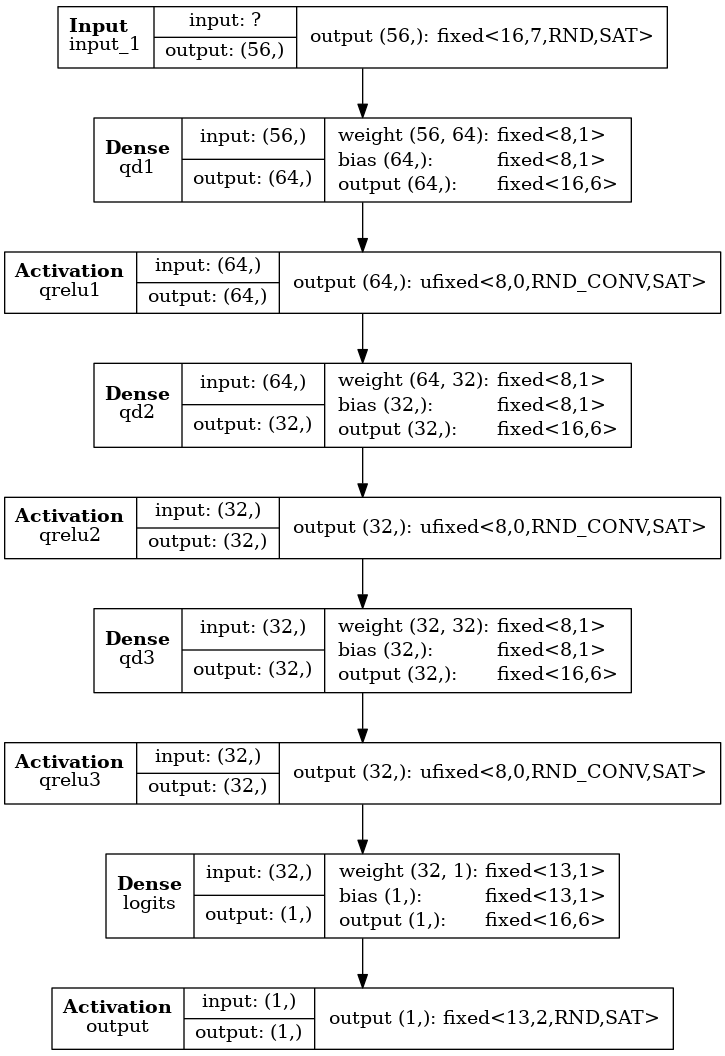

In [17]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Here you can see that the precision is what we set it to be in QKeras as well as what we set manually in the config. One thing to note is the different definitions used in QKeras and in ap_fixed:
- ```quantized_bits(8,0) -> ap_fixed<8,1>```
- ```quantized_relu(8,0) -> ap_ufixed<8,0>```
Also you can see that the defualt value for result/accu is set to $16,6$. This can also be tuned to more optimal values.

## Validate the firmware model accuracy

#et's also run predict on the C++ implementation of our model and make sure it's the ~same as for the QKeras model.
This is very slow for the C++ implementation of our model, but we need a lot of statistics to probe the low rate region. Keep reading while you wait :)!


In [18]:
y_hls = hls_model.predict(np.ascontiguousarray(qX_test))

print(f"Truth labels:\n {y_test[17:27]}\n")
print(f"Qkeras prediction:\n {qy_pred[17:27]}\n")
print(f"HLS prediction:\n {y_hls[17:27]}\n")

Truth labels:
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

Qkeras prediction:
 [[2.4330037e-04]
 [9.9666774e-01]
 [2.4369828e-04]
 [8.1537422e-03]
 [2.4510574e-04]
 [2.7655961e-03]
 [3.4783210e-04]
 [3.7922856e-04]
 [3.3851471e-04]
 [2.4369828e-04]]

HLS prediction:
 [[0.        ]
 [0.99609375]
 [0.        ]
 [0.0078125 ]
 [0.        ]
 [0.00292969]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]



<module 'matplotlib.pyplot' from '/cvmfs/cms.cern.ch/slc7_amd64_gcc11/external/py3-matplotlib/3.7.1-437a2eea83d29aac3bc5f3984f238002/lib/python3.9/site-packages/matplotlib/pyplot.py'>

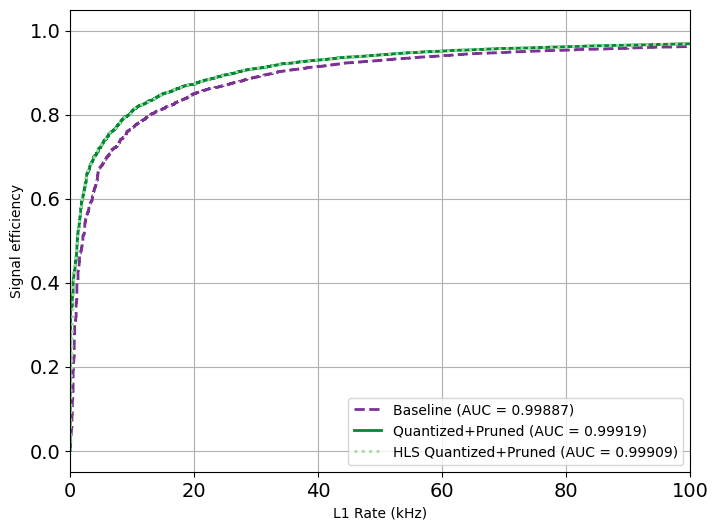

In [19]:
# Lets plot it!
hlsfpr, hlstpr, hlsthr = roc_curve(y_test, y_hls, pos_label=1, sample_weight=None, drop_intermediate=True)
hlsfpr *= totalMinBiasRate()
hlsroc_auc = roc_auc_score(y_test, y_hls)

f, ax  = plt.subplots(figsize=(8,6))
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14) 
ax.set_xlim(0,100)

ax.plot(fpr, tpr, color='#7b3294', lw=2, ls='dashed', label=f'Baseline (AUC = {roc_auc:.5f})')
ax.plot(qfpr, qtpr, color='#008837', lw=2, label=f'Quantized+Pruned (AUC = {qroc_auc:.5f})')
ax.plot(hlsfpr, hlstpr, color='#a6dba0', lw=2, ls='dotted', label=f'HLS Quantized+Pruned (AUC = {hlsroc_auc:.5f})')
ax.set_xlabel('L1 Rate (kHz)')
ax.set_ylabel('Signal efficiency')
ax.legend(loc="lower right")
ax.grid(True)
plt

Oh! That was easier than expected. If you see the accuracies differing significantly, it's a good idea to look into accumulator and reult precisions. Also with tools like $Trace$ and $Profiling$ that you can learn from in the [official hls4ml tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial/blob/main/part2_advanced_config.ipynb) can be helpful! In this case, it doesnt seem like it's necessary. 

## Synthesise!

Now let's build it! Lets run C-synthesis (C++ to register-transfer level) and Vivado logic synthesis (gate level representation). We will not do co-simulation (send test vectors, do an exhaustive functional test of the implemented logic), but this can be a good idea if you are using CNNs and the $io_stream$ io. 

Let's run!

In [20]:
report = hls_model.build(csim=False, synth=True, vsynth=True, cosim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'thaarres' on host 'lxplus773.cern.ch' (Linux_x86_64 version 3.10.0-1160.102.1.el7.x86_64) on Thu Dec 07 16:11:03 CET 2023
INFO: [HLS 200-10] In directory '/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1/L1TMLDemo_v1_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/L1TMLDemo_v1.cpp' to the project
INFO: [HLS 200-10] Adding test benc

INFO: [HLS 200-489] Unrolling loop 'ResetAccum' (firmware/nnet_utils/nnet_dense_latency.h:48) in function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum1' (firmware/nnet_utils/nnet_dense_latency.h:54) in function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Accum2' (firmware/nnet_utils/nnet_dense_latency.h:56) in function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>' completely with a factor of 32.
INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_latency.h:64) in function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:65) by setting 'weights.V' to 'w11.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0'(firmware/nnet_utils/nnet_dense_latency.h:26:1) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config11>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:65) by setting 'biases.V' to 'b11.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:57) by setting 'biases[17].V' to 'b8.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config8>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:49) by setting 'weights.V' to 'w5.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:49) by setting 'biases[0].V' to 'b5.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8,

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:41->firmware/L1TMLDemo_v1.cpp:49) by setting 'biases[17].V' to 'b5.V.17'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_ufixed<8, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/nnet_utils/nnet_dense.h:

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0' by setting 'weights.V' to 'w2.V'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[19].V' to 'b2.V.19'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fix

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[37].V' to 'b2.V.37'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[53].V' to 'b2.V.53'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:26:9) to 'nnet::dense_latency<ap_fixed<16, 7, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<1

INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:08:24 ; elapsed = 00:09:32 . Memory (MB): peak = 15518.676 ; gain = 15087.191 ; free physical = 7157 ; free virtual = 17921
INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:08:28 ; elapsed = 00:09:37 . Memory (MB): peak = 15518.676 ; gain = 15087.191 ; free physical = 7144 ; free virtual = 17915
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'L1TMLDemo_v1' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.'.
INFO: [SCHED 204-61] Pipelining result : Target II =

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.42 seconds; current allocated memory: 312.363 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.88 seconds; current allo

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_ufixed_8_0_4_0_0_ap_fixed_16_6_5_3_0_config11_0_0' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_latency_ap_ufixed_8_0_4_0_0_ap_fixed_16_6_5_3_0_config11_0_0'.
INFO: [HLS 200-111]  Elapsed time: 2.69 seconds; current allocated memory: 404.717 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_ap_fixed_16_6_5_3_0_ap_fixed_13_2_0_0_0_sigmoid_config13_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_ap_fixed_16_6_5_3_0_ap_fixed_13_2_0_0_0_sigmoid_config13_s_sigmoid_table1' to 'sigmoid_ap_fixed_16_6_5_3_0_ap_fixed_13_2_0_0_0_sigmoid_config13_s_sigmoid_tabkb' due to 

INFO: [Synth 8-256] done synthesizing module 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config10_s' (4#1) [/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1/L1TMLDemo_v1_prj/solution1/syn/vhdl/relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config10_s.vhd:68]
INFO: [Synth 8-3491] module 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config4_s' declared at '/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1/L1TMLDemo_v1_prj/solution1/syn/vhdl/relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config4_s.vhd:12' bound to instance 'call_ret1_relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config4_s_fu_128' of component 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config4_s' [/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1/L1TMLDemo_v1_prj/solution1/syn/vhdl/L1TMLDemo_v1.vhd:818]
INFO: [Synth 8-638] synthesizing module 'relu_ap_fixed_16_6_5_3_0_ap_ufixed_8_0_4_0_0_relu_config4_s' [/afs/cern.ch/work/t/thaarres/cms

INFO: [Synth 8-256] done synthesizing module 'L1TMLDemo_v1' (11#1) [/afs/cern.ch/work/t/thaarres/cms_mlatl1t_tutorial/part2/L1TMLDemo_v1/L1TMLDemo_v1_prj/solution1/syn/vhdl/L1TMLDemo_v1.vhd:27]
INFO: [Common 17-14] Message 'Synth 8-3331' appears 100 times and further instances of the messages will be disabled. Use the Tcl command set_msg_config to change the current settings.


---------------------------------------------------------------------------------
Finished Synthesize : Time (s): cpu = 00:00:05 ; elapsed = 00:00:09 . Memory (MB): peak = 1715.828 ; gain = 258.434 ; free physical = 5239 ; free virtual = 17365
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Constraint Validation : Time (s): cpu = 00:00:05 ; elapsed = 00:00:10 . Memory (MB): peak = 1733.641 ; gain = 276.246 ; free physical = 5033 ; free virtual = 17161
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Start Loading Part and Timing Information
---------------------------------------------------------------------------------
Loading part: xcu250-figd2104-2L-e
INFO: [Synth 8-6742] Reading net delay rules and data
INFO: [Device 21-403] Loading part xcu250-

Part Resources:
DSPs: 12288 (col length:96)
BRAMs: 5376 (col length: RAMB18 384 RAMB36 192)
---------------------------------------------------------------------------------
Finished Part Resource Summary
---------------------------------------------------------------------------------
No constraint files found.
---------------------------------------------------------------------------------
Start Cross Boundary and Area Optimization
---------------------------------------------------------------------------------
DSP Report: Generating DSP mul_ln1118_40_fu_539_p2, operation Mode is: A*(B:0x3ffba).
DSP Report: operator mul_ln1118_40_fu_539_p2 is absorbed into DSP mul_ln1118_40_fu_539_p2.
DSP Report: Generating DSP mul_ln1118_56_fu_463_p2, operation Mode is: A*(B:0x3ffc6).
DSP Report: operator mul_ln1118_56_fu_463_p2 is absorbed into DSP mul_ln1118_56_fu_463_p2.
DSP Report: Generating DSP mul_ln1118_41_fu_509_p2, operation Mode is: A*(B:0x32).
DSP Report: operator mul_ln1118_41_fu_509_

INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/tmp_6_reg_22271_reg[0]' (FD) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/sext_ln1118_24_reg_22279_reg[3]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/tmp_6_reg_22271_reg[1]' (FD) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/sext_ln1118_24_reg_22279_reg[4]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/sext_ln1118_24_reg_22279_reg[19]' (FD) to 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_s_fu_75/sext_ln1118_24_reg_22279_reg[18]'
INFO: [Synth 8-3886] merging instance 'grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0

INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer7_out_17_V_reg_836_reg[7] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer10_out_26_V_reg_1101_reg[6] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer10_out_26_V_reg_1101_reg[7] )
INFO: [Synth 8-3333] propagating constant 1 across sequential element (\layer10_out_14_V_reg_1046_reg[4] )
INFO: [Synth 8-3333] propagating constant 1 across sequential element (\layer10_out_14_V_reg_1046_reg[5] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer10_out_14_V_reg_1046_reg[6] )
INFO: [Synth 8-3333] propagating constant 0 across sequential element (\layer10_out_14_V_reg_1046_reg[7] )
INFO: [Synth 8-3333] propagating constant 1 across sequential element (grp_dense_latency_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_0_1_fu_81/\acc_17_V_reg_11956_reg[6] )
INFO: [Synth 8-3333] propagating constant 0 across sequential


Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
No constraint files found.
---------------------------------------------------------------------------------
Start Timing Optimization
---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
Finished Timing Optimization : Time (s): cpu = 00:00:54 ; elapsed = 00:01:25 . Memory (MB): peak = 2790.801 ; gain = 1333.406 ; free physical = 3392 ; free virtual = 15898
---------------------------------------------------------------------------------

Report RTL Partitions: 
+-+--------------+------------+----------+
| |RTL Partition |Replication |Instances |
+-+--------------+------------+----------+
+-+--------------+------------+----------+
-----------------------------------------------------

INFO: [Project 1-571] Translating synthesized netlist
Netlist sorting complete. Time (s): cpu = 00:00:00.11 ; elapsed = 00:00:00.12 . Memory (MB): peak = 2794.965 ; gain = 0.000 ; free physical = 2904 ; free virtual = 15420
INFO: [Netlist 29-17] Analyzing 1717 Unisim elements for replacement
INFO: [Netlist 29-28] Unisim Transformation completed in 0 CPU seconds
INFO: [Project 1-570] Preparing netlist for logic optimization
INFO: [Opt 31-138] Pushed 0 inverter(s) to 0 load pin(s).
Netlist sorting complete. Time (s): cpu = 00:00:00 ; elapsed = 00:00:00 . Memory (MB): peak = 2871.824 ; gain = 0.000 ; free physical = 3515 ; free virtual = 16076
INFO: [Project 1-111] Unisim Transformation Summary:
  A total of 815 instances were transformed.
  BUFG => BUFGCE: 1 instance 
  DSP48E2 => DSP48E2 (DSP_ALU, DSP_A_B_DATA, DSP_C_DATA, DSP_MULTIPLIER, DSP_M_DATA, DSP_OUTPUT, DSP_PREADD, DSP_PREADD_DATA): 45 instances
  IBUF => IBUF (IBUFCTRL, INBUF): 769 instances

INFO: [Common 17-83] Releasing lic

Now, lets, look at the reports! The latency can be extracted from the C-synthesis report, and validated from the co-simulation report (where actual data is sent through the logic. 

The resource consumption can be extracted from the implementation report (Vivado logic synthesis) and is more accurate then what is quoted in the C-synthesis report. 

In this case we did not run co-simulation (this mainly because important when using CNNs and io_stream), but lets print the rest:

In [21]:
print("\nC synthesis report (latency estimate):")
print_dict(report["CSynthesisReport"])
#print_dict(report["CosimReport"]) # If also running co-sim
print("\nVivado synthesis report (resource estimates):")
print_dict(report["VivadoSynthReport"])


C synthesis report (latency estimate):
TargetClockPeriod:   2.50
EstimatedClockPeriod:2.176
BestLatency:         15
WorstLatency:        15
IntervalMin:         1
IntervalMax:         1
BRAM_18K:            1
DSP:                 47
FF:                  5914
LUT:                 17754
URAM:                0
AvailableBRAM_18K:   5376
AvailableDSP:        12288
AvailableFF:         3456000
AvailableLUT:        1728000
AvailableURAM:       1280

Vivado synthesis report (resource estimates):
LUT:                 8436
FF:                  4511
BRAM_18K:            0.5
URAM:                0
DSP48E:              45


A latency of $2.5\cdot15=37.5$ ns, that is not bad! 

Also, the network is using very little resources: 8k out of 1728k LUTs, 45 out of 12k DSPs. This is <1% of the total available resources.  We have a set of HLS files that will be integrated into the CMSSW emulator (```L1TMLDemo_v1/firmware/```) and VHDL that will be integrated into the mGT firmware (```L1TMLDemo_v1/myproject_prj/solution1/impl/vhdl/```). That's next!

If you did not finish synthesising before the start of the next exercise, you can copy an already synthesised project from here:

In [22]:
# ! cp /eos/home-t/thaarres/cms_mlatl1t_tutorial/L1TMLDemo_v1.tar.gz
# ! tar -xzvf 